# DQN Agent for MineRLTreechop-v0


In [1]:
import os
import gym
import minerl
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
from stable_baselines3.common.callbacks import CheckpointCallback, BaseCallback
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.utils import set_random_seed
from IPython.display import clear_output


### Environment Setup

In [ ]:
os.environ['MALMO_MINECRAFT_OUTPUT_LOG'] = 'true'
os.environ['MALMO_MINECRAFT_INITIAL_MEMORY'] = '16G'
os.environ['MALMO_MINECRAFT_MAX_MEMORY'] = '32G'
os.environ['MINERL_HEADLESS'] = '1'
os.environ['MINERL_DISABLE_HUB'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Force CPU

minerl.env.ENV_KWARGS = {
    'timeout': 30000,
    'retry_on_timeout': True,
    'retry_count': 3,
}

set_random_seed(42)
os.makedirs("models_dqn", exist_ok=True)
os.makedirs("logs_dqn", exist_ok=True)

### Custon CNN

In [3]:
class MinecraftCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=512):
        in_channels = observation_space.shape[0]
        super(MinecraftCNN, self).__init__(observation_space, features_dim)
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), nn.ReLU(),
            nn.Flatten()
        )
        # compute the output size after conv layers
        with torch.no_grad():
            sample_input = torch.zeros(1, *observation_space.shape)
            n_flatten = self.cnn(sample_input).shape[1]
        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, x):
        return self.linear(self.cnn(x))


### Wrappers for MineRL

In [4]:
class PovWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(0, 255, (3, 64, 64), dtype=np.uint8)

    def observation(self, observation):
        pov = observation["pov"]
        return np.transpose(pov, (2, 0, 1))  # HWC → CHW
class ActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.actions = [
            {"forward": 1, "jump": 1, "attack": 1, "camera": [0, 10]},  # Look up + move
            {"forward": 1, "jump": 0, "attack": 1, "camera": [0, 0]},   # Straight ahead
            {"forward": 0, "jump": 0, "attack": 1, "camera": [0, -5]},  # Look down
        ]
        self.action_space = gym.spaces.Discrete(len(self.actions))

    def action(self, act):
        return self.actions[act]

class ErrorHandlingWrapper(gym.Wrapper):
    def reset(self, **kwargs):
        for _ in range(3):
            try:
                return self.env.reset(**kwargs)
            except Exception:
                pass
        raise RuntimeError("Env failed to reset after retries.")

    def step(self, action):
        for _ in range(3):  # Retry failed steps
            try:
                return self.env.step(action)
            except Exception:
                pass
        return self.reset(), 0, True, {}

### Environment Creator

In [5]:
def make_env():
    def _init():
        env = gym.make("MineRLTreechop-v0")
        env.render_mode = 'rgb_array'
        env = ActionWrapper(env)
        env = PovWrapper(env)
        env = ErrorHandlingWrapper(env)
        return env
    return _init

### DQN Training

In [6]:
class LossTrackingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.losses = []

    def _on_step(self) -> bool:
        # Only OffPolicyAlgorithms like DQN have `logger.name_to_value`
        if hasattr(self.model, "logger") and "train/loss" in self.model.logger.name_to_value:
            loss = self.model.logger.name_to_value["train/loss"]
            self.losses.append(loss)
        return True

In [7]:
def train_dqn_agent():
    train_env = DummyVecEnv([make_env()])
    train_env = VecFrameStack(train_env, n_stack=2)
    
    # Model Setup
    policy_kwargs = dict(
        features_extractor_class=MinecraftCNN,
        features_extractor_kwargs=dict(features_dim=512)
    )

    model = DQN(
        "CnnPolicy", 
        train_env, 
        learning_rate=1e-4, 
        buffer_size=10000,
        learning_starts=500,
        batch_size=64,
        tau=1.0,
        gamma=0.99,
        train_freq=4,
        target_update_interval=1000,
        exploration_fraction=0.5,
        exploration_final_eps=0.1,
        policy_kwargs=policy_kwargs,
        verbose=1,
        tensorboard_log="./logs_dqn/"
    )
    
    # callbacks
    checkpoint_callback = CheckpointCallback(
        save_freq=10000,
        save_path='./models_dqn/',
        name_prefix='dqn_treechop'
    )
    loss_callback = LossTrackingCallback()
    

    model.learn(total_timesteps=100_000, progress_bar=True,callback=[checkpoint_callback, loss_callback])
    
    # Save metrics
    model.save("models_dqn/final_dqn_treechop")
    np.save("train_losses.npy", loss_callback.losses)
    train_env.close()
    

### Run

In [ ]:
train_dqn_agent()

### Evaluation
we can change this evaluation once the agent has been trained. Changing the num_episodes etc for plotting.

In [8]:
def evaluate_dqn_agent(model_path="models_dqn/final_dqn_treechop", num_episodes=5, save_path="eval_metrics.npz", log_interval=1):

    # Match training environment setup
    env = DummyVecEnv([make_env()])
    eval_env = VecFrameStack(env, n_stack=2)

    # Load the trained model
    model = DQN.load(model_path)

    total_rewards = []
    episode_lengths = []

    print(f"Evaluating over {num_episodes} episodes...")
    for ep in tqdm(range(num_episodes), desc="Evaluation Progress"):
        obs = eval_env.reset()
        done = False
        episode_reward = 0
        length = 0

        while not done:
            obs_contiguous = np.ascontiguousarray(obs)  # Prevent stride-related issues
            action, _ = model.predict(obs_contiguous, deterministic=True)
            obs, reward, done, _ = eval_env.step(action)
            episode_reward += reward.item()
            length += 1

        total_rewards.append(episode_reward)
        episode_lengths.append(length)

        if (ep + 1) % log_interval == 0:
            print(f"Episode {ep+1} | Reward: {episode_reward:.2f} | Length: {length}")

    # Save evaluation metrics
    np.savez(save_path, rewards=total_rewards, lengths=episode_lengths)
    print(f"\nSaved evaluation results to {save_path}")
    print(f"Average Reward: {np.mean(total_rewards):.2f} | Average Length: {np.mean(episode_lengths):.2f}")

    eval_env.close()


### Run

In [9]:
evaluate_dqn_agent()

/home/pateltirth2001/.local/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Evaluating over 5 episodes...


Evaluation Progress:   0%|          | 0/5 [00:00<?, ?it/s]/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'minerl.utils.process_watcher' found in sys.modules after import of package 'minerl.utils', but prior to execution of 'minerl.utils.process_watcher'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
Evaluation Progress:  20%|██        | 1/5 [05:34<22:16, 334.23s/it]

Episode 1 | Reward: 0.00 | Length: 8000


Evaluation Progress:  40%|████      | 2/5 [10:39<15:50, 316.99s/it]

Episode 2 | Reward: 0.00 | Length: 8000


Evaluation Progress:  60%|██████    | 3/5 [16:20<10:55, 327.99s/it]

Episode 3 | Reward: 0.00 | Length: 8000


Evaluation Progress:  80%|████████  | 4/5 [20:59<05:08, 308.65s/it]

Episode 4 | Reward: 0.00 | Length: 8000


Evaluation Progress: 100%|██████████| 5/5 [25:36<00:00, 307.22s/it]

Episode 5 | Reward: 0.00 | Length: 8000

Saved evaluation results to eval_metrics.npz
Average Reward: 0.00 | Average Length: 8000.00


### Plotting Routine

In [10]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    data = np.array(data)
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

In [13]:
def plot_eval_metrics(rewards_file="eval_metrics.npz"):
    data = np.load(rewards_file)
    rewards = data["rewards"]
    lengths = data["lengths"]
    losses = np.load("train_losses.npy")

    fig, axs = plt.subplots(3, 1, figsize=(10, 12))

    axs[0].plot(rewards, label="Evaluation Rewards")
    axs[0].plot(moving_average(rewards), label="Moving Average")
    axs[0].axhline(np.mean(rewards), color="r", linestyle="--", label=f"Mean: {np.mean(rewards):.2f}")
    axs[0].set_title("Evaluation Rewards")
    axs[0].set_ylabel("Reward")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(lengths, label="Episode Lengths", color="orange")
    axs[1].set_title("Episode Lengths")
    axs[1].set_ylabel("Steps")
    axs[1].legend()
    axs[1].grid(True)

    axs[2].plot(losses, label="Training Loss", color="green", alpha=0.7)
    axs[2].set_title("Training Losses")
    axs[2].set_xlabel("Training Steps")
    axs[2].set_ylabel("Loss")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()



# === Load Training Rewards from TensorBoard ===
def plot_training_rewards(tb_log_dir="logs_dqn/DQN_2/"):  # change folder as needed
    event_acc = EventAccumulator(tb_log_dir)
    event_acc.Reload()
    rewards = event_acc.Scalars("train/loss")

    steps = [e.step for e in rewards]
    values = [e.value for e in rewards]

    plt.figure(figsize=(8, 5))
    plt.plot(steps, values, label="Train Loss (Mean)")
    plt.xlabel("Timesteps")
    plt.ylabel("Loss")
    plt.title("DQN Training Loss (Mean Episode Loss)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


### Run

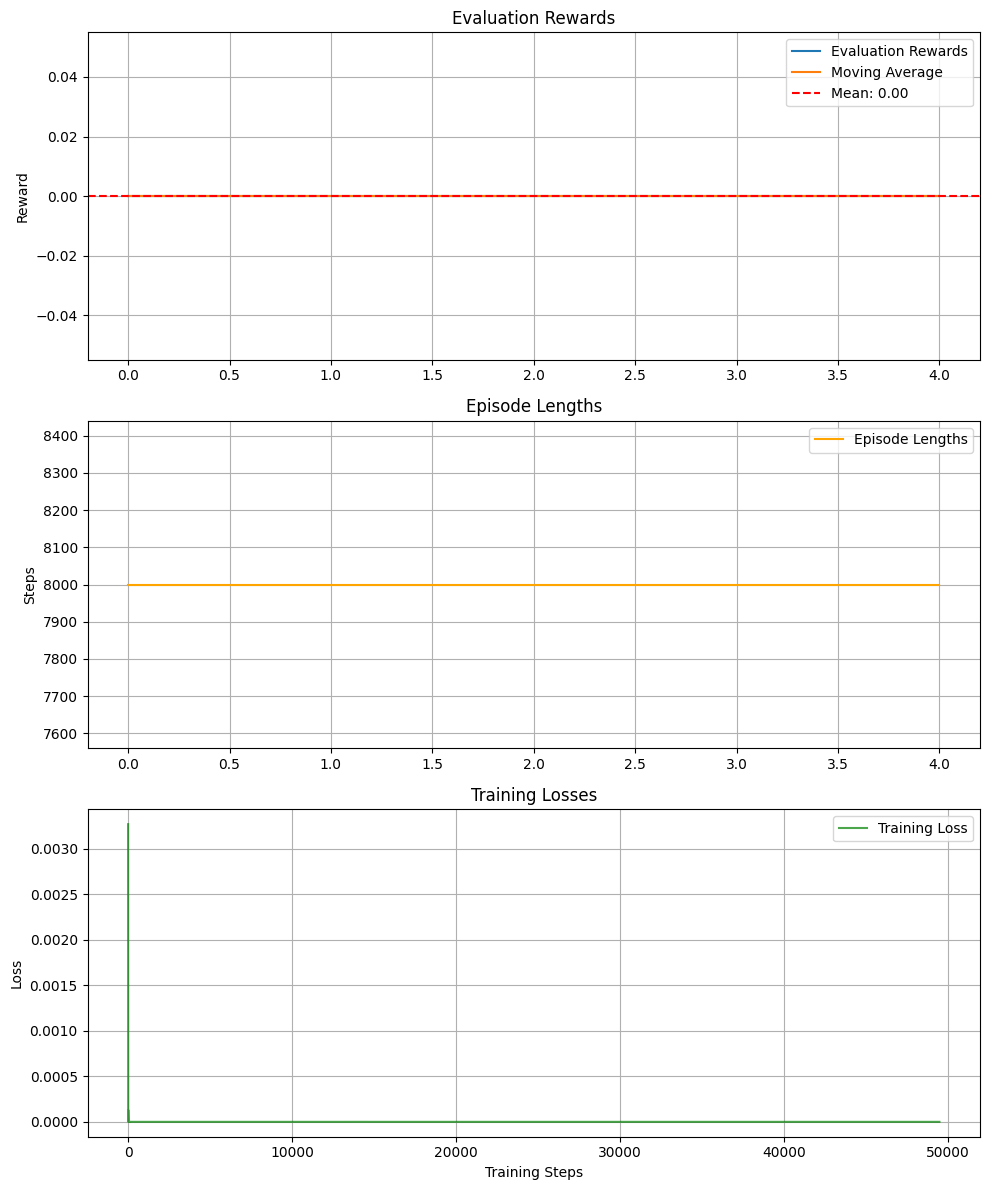

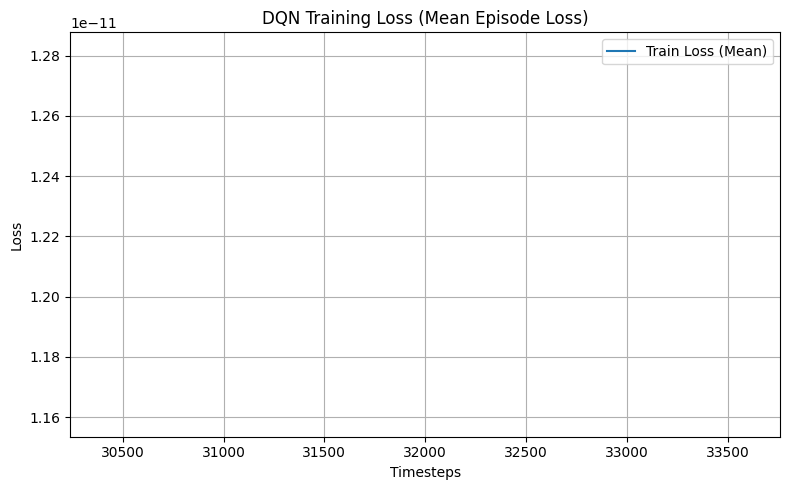

In [14]:
plot_eval_metrics()
plot_training_rewards()

### Running Simulation

In [23]:
import imageio
from collections import deque

# Load the trained model
model = DQN.load("models_dqn/final_dqn_treechop")  # Update path if needed

# Initialize raw environment
env = gym.make("MineRLTreechop-v0")
env = ActionWrapper(env)
env = PovWrapper(env)
env = ErrorHandlingWrapper(env)

# Initial observation
obs = env.reset()
frames = []
done = False
total_reward = 0

# 🌀 Set up a deque for stacking 2 frames
frame_stack = deque(maxlen=2)
frame_stack.append(obs)
frame_stack.append(obs)  # Repeat first frame to fill stack

for step in range(1000):
    
    # Convert list of stacked frames: [(64, 64, 3), (64, 64, 3)] -> (64, 64, 6)
    stacked = np.concatenate(list(frame_stack), axis=0)  # (H, W, C*num_stack) = (6, 64, 64)

    # Predict
    action, _ = model.predict(stacked, deterministic=True)

    # Step
    obs, reward, done, info = env.step(action)

    frame_stack.append(obs)

    # Render and append frame
    frame = env.render(mode='rgb_array')
    if frame is not None and frame.shape == (64, 64, 3):
        frames.append(frame)
    
    total_reward += reward
    
    if step > 998:
        print(f"Episode finished! Total reward: {total_reward}")
        break
        
    
# Save video
if frames:
    imageio.mimsave("simulation.mp4", frames, fps=10)
    print("🎥 Saved simulation.mp4")
else:
    print("⚠️ No frames were collected.")


/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'minerl.utils.process_watcher' found in sys.modules after import of package 'minerl.utils', but prior to execution of 'minerl.utils.process_watcher'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


Episode finished! Total reward: 0.0
🎥 Saved simulation.mp4


### Delete later